In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [4]:
# # Color for plots
# color_mean = 'blue'
# color_lo = 'orange'
# color_hi = 'green'
# color_min = 'red'
# color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [7]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [8]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [9]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [10]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [11]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [12]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [13]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [14]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [15]:
# Mixture parameters
num_hits: int = 20
R_deg: float = 0.5

In [16]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, score_by_elt=score_by_elt, num_hits=num_hits, R_deg=R_deg)

In [17]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [18]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,h,R
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,0.001573,0.008727
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,0.001681,0.008727
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,0.001591,0.008727
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,0.002034,0.008727
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,0.002191,0.008727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,0.002207,0.008727
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,0.001961,0.008727
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,0.002985,0.008727
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,0.004413,0.008727


## Train on Random Elements: Learn Mixture Parameters

In [19]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [20]:
# Training parameters
learning_rate = 2.0**-15
clipnorm = 1.0

In [21]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [22]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :     1.99  :   0.00 :  0.500000 :  1800.00 : 2.000000
Std  :     0.99  :   0.00 :  0.000000 :     0.00 : 0.000000
Min  :     0.44  :   0.00 :  0.500000 :  1800.00 : 2.000000
Max  :     5.09  :   0.00 :  0.500000 :  1800.00 : 2.000000


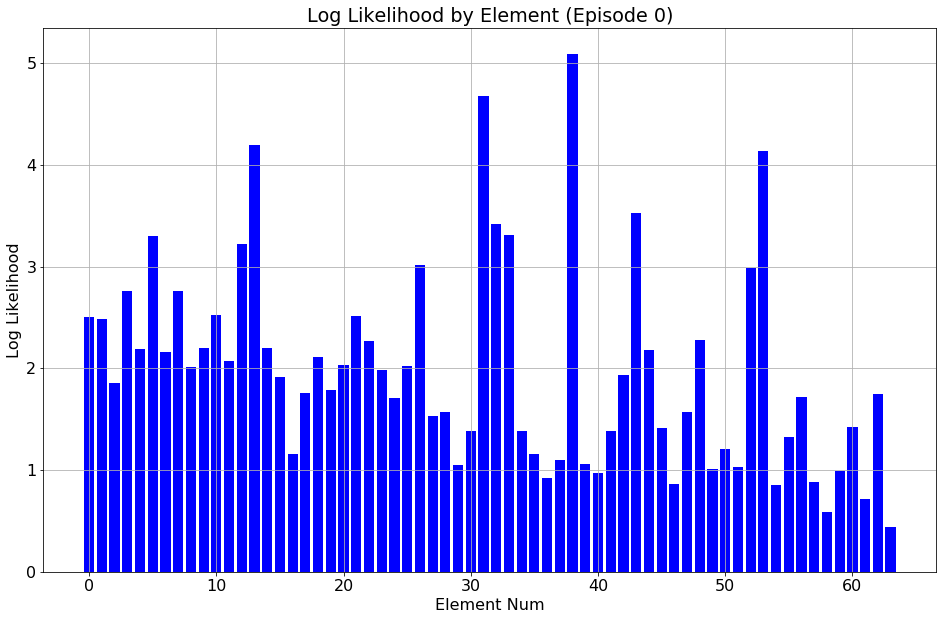

In [23]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [24]:
# Adaptive search parameters
batches_per_epoch = 100
epochs_per_episode = 5
thresh_deg_end = None
max_bad_episodes = 3
min_learning_rate = None
save_at_end = False
reset_active_weight = False
verbose = 1

In [25]:
# # Load model
# model.load()
# model.report()

In [26]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [27]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=model.current_batch+2000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 0: Epoch    0, Batch      0
effective_learning_rate=3.052e-05, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 5s 719us/sample - loss: -388.9029
Epoch 2/5
6400/6400 [==============================] - 2s 375us/sample - loss: -669.6584
Epoch 3/5
6400/6400 [==============================] - 2s 384us/sample - loss: -940.6444
Epoch 4/5
6400/6400 [==============================] - 2s 388us/sample - loss: -1195.7173
Epoch 5/5
6400/6400 [==============================] - 3s 392us/sample - loss: -1429.5061
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
Geom Mean Resolution: 0.436901 degrees (1572.8 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:      9.87

Training episode 1: Epoch    5, Batch    500
effective_learning_rate=3.028e-05, training_time 21 sec.
Train on 6400 samples
Epoch 6/10
6400/6400 [==============================] - 2s 390us/sample - loss: -1624.8791
Epoch 7/10
640

In [28]:
# Report after initial training on mixture parameters
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    13.48  :   0.00 :  0.443417 :  1596.30 : 2.000000
Std  :     8.70  :   0.00 :  0.075304 :   271.09 : 0.000000
Min  :     0.56  :   0.00 :  0.334845 :  1205.44 : 2.000000
Max  :    33.68  :   0.00 :  0.669595 :  2410.54 : 2.000000


In [29]:
model.freeze_score()

In [30]:
# # Save model
# model.save_state()

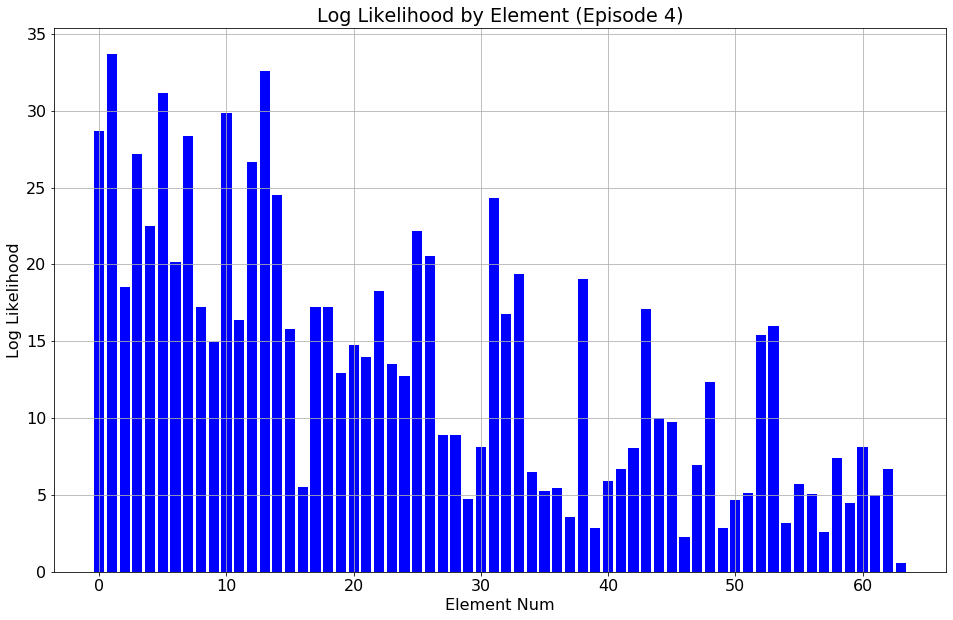

In [31]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [32]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('hits', sorted=False)

In [33]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [34]:
# # Threshold in degrees
# fig, ax = model.plot_bar('thresh_deg_score', sorted=False)

## Train on Orbital Elements & Mixture Parameters

In [35]:
# Unfreeze the elements
model.thaw_candidate_elements()

In [36]:
# Train in joint mode; learn elements, mixture_parameters; threshold frozen
model.search_adaptive(
    max_batches=model.current_batch+10000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_start=2.0,
    thresh_deg_end=1.0,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 4: Epoch   20, Batch   2000
effective_learning_rate=1.490e-05, training_time 59 sec.
Updating thresh_deg. episode_batch 0 / 10000 ( 0.0%); thresh_deg_max = 2.000000 (factor 1.000000 from start).
Train on 6400 samples
Epoch 21/25
6400/6400 [==============================] - 5s 723us/sample - loss: -6528.7025
Epoch 22/25
6400/6400 [==============================] - 3s 461us/sample - loss: -8432.1732
Epoch 23/25
6400/6400 [==============================] - 3s 467us/sample - loss: -9663.6512
Epoch 24/25
6400/6400 [==============================] - 3s 469us/sample - loss: -10652.4518
Epoch 25/25
6400/6400 [==============================] - 3s 464us/sample - loss: -11460.0024
Geom Mean Resolution: 0.360760 degrees (1298.7 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:    137.62

Training episode 5: Epoch   25, Batch   2500
effective_learning_rate=1.490e-05, training_time 78 sec.
Updating thresh_deg. episode_batch 500 / 10000 ( 5.0%); thresh_deg_max = 1.931

In [38]:
# Report after training
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    47.21  :   0.00 :  0.490651 :  1766.34 : 1.035265
Std  :    31.41  :   0.00 :  0.206857 :   744.69 : 0.000000
Min  :    -3.41  :   0.00 :  0.180824 :   650.97 : 1.035265
Max  :   129.83  :   0.00 :  0.999962 :  3599.86 : 1.035265


In [ ]:
# model.save_state()

In [42]:
# Freeze elements; train mixture
model.freeze_candidate_elements()
model.freeze_score()

In [43]:
model.search_adaptive(
    max_batches=model.current_batch+2000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 24: Epoch  120, Batch  12000
effective_learning_rate=1.022e-05, training_time 412 sec.
Train on 6400 samples
Epoch 121/125
6400/6400 [==============================] - 4s 598us/sample - loss: -2277.4604
Epoch 122/125
6400/6400 [==============================] - 3s 456us/sample - loss: -2288.6005
Epoch 123/125
6400/6400 [==============================] - 3s 449us/sample - loss: -2294.6542
Epoch 124/125
6400/6400 [==============================] - 3s 441us/sample - loss: -2299.0987
Epoch 125/125
6400/6400 [==============================] - 3s 452us/sample - loss: -2302.6268
Adjusted element weight down on 38 candidate elements. Mean weight = 3.45e-01
Geom Mean Resolution: 0.443391 degrees (1596.2 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:     47.86

Training episode 25: Epoch  125, Batch  12500
effective_learning_rate=1.052e-05, training_time 522 sec.
Train on 6400 samples
Epoch 126/130
6400/6400 [==============================] - 3s 457us/sample -

In [44]:
# Freeze elements; freeze mixture; train score
model.freeze_candidate_elements()
model.freeze_mixture_parameters()
model.freeze_score()

In [45]:
model.search_adaptive(
    max_batches=model.current_batch+1000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 28: Epoch  140, Batch  14000
effective_learning_rate=6.136e-06, training_time 567 sec.
Train on 6400 samples
Epoch 141/145
6400/6400 [==============================] - 3s 491us/sample - loss: -5079.9552
Epoch 142/145
6400/6400 [==============================] - 3s 398us/sample - loss: -5079.9551
Adjusted element weight down on 28 candidate elements. Mean weight = 7.81e-01
Increasing bad_episode_count to 1.
Geom Mean Resolution: 0.441557 degrees (1589.6 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:     48.68

Training episode 29: Epoch  142, Batch  14200
effective_learning_rate=2.384e-05, training_time 599 sec.
Train on 6400 samples
Epoch 143/147
6400/6400 [==============================] - 3s 400us/sample - loss: -4084.6769
Epoch 144/147
6400/6400 [==============================] - 3s 406us/sample - loss: -4084.6769
Adjusted element weight down on 26 candidate elements. Mean weight = 6.29e-01
Increasing bad_episode_count to 2.
Geom Mean Resolution: 

In [48]:
# # Bar chart 
# fig, ax = model.plot_bar('thresh_deg_score', sorted=True)

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

## Extended Training

In [49]:
# Train on elements only
model.thaw_candidate_elements()
model.freeze_mixture_parameters()
model.freeze_score()

In [50]:
model.search_adaptive(
    max_batches=model.current_batch+2000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 31: Epoch  147, Batch  14700
effective_learning_rate=1.591e-05, training_time 613 sec.
Train on 6400 samples
Epoch 148/152
6400/6400 [==============================] - 5s 759us/sample - loss: -2798.1571
Epoch 149/152
6400/6400 [==============================] - 3s 542us/sample - loss: -2835.1317
Epoch 150/152
6400/6400 [==============================] - 3s 543us/sample - loss: -2837.4610
Epoch 151/152
6400/6400 [==============================] - 4s 548us/sample - loss: -2838.4201
Epoch 152/152
6400/6400 [==============================] - 4s 549us/sample - loss: -2839.6743
Adjusted element weight down on 33 candidate elements. Mean weight = 3.95e-01
Geom Mean Resolution: 0.441557 degrees (1589.6 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:     49.23

Training episode 32: Epoch  152, Batch  15200
effective_learning_rate=1.204e-05, training_time 728 sec.
Train on 6400 samples
Epoch 153/157
6400/6400 [==============================] - 4s 555us/sample -

In [51]:
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    49.78  :   0.00 :  0.489157 :  1760.96 : 1.035265
Std  :    32.85  :   0.00 :  0.212701 :   765.72 : 0.000000
Min  :    -0.09  :   0.00 :  0.104577 :   376.48 : 1.035265
Max  :   130.03  :   0.00 :  0.999962 :  3599.86 : 1.035265


In [52]:
model.save_state()

In [56]:
model.thaw_candidate_elements()
model.thaw_mixture_parameters()

In [57]:
model.search_adaptive(
    max_batches=model.current_batch+10000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_start=1.0,
    thresh_deg_end=0.50,
    reset_active_weight=reset_active_weight,    
    verbose=verbose)


Training episode 35: Epoch  167, Batch  16700
effective_learning_rate=5.264e-06, training_time 787 sec.
Updating thresh_deg. episode_batch 0 / 10000 ( 0.0%); thresh_deg_max = 1.000000 (factor 1.000000 from start).
Train on 6400 samples
Epoch 168/172
6400/6400 [==============================] - 5s 795us/sample - loss: -1241.7873
Epoch 169/172
6400/6400 [==============================] - 4s 576us/sample - loss: -1249.1005
Epoch 170/172
6400/6400 [==============================] - 4s 575us/sample - loss: -1254.9596
Epoch 171/172
6400/6400 [==============================] - 4s 570us/sample - loss: -1260.4858
Epoch 172/172
6400/6400 [==============================] - 4s 583us/sample - loss: -1263.6676
Adjusted element weight down on 30 candidate elements. Mean weight = 2.96e-01
Geom Mean Resolution: 0.439319 degrees (1581.5 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:     47.82

Training episode 36: Epoch  172, Batch  17200
effective_learning_rate=9.048e-06, training_ti

In [58]:
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    28.17  :   0.91 :  0.507218 :  1825.98 : 0.503478
Std  :    27.30  :   7.19 :  0.245502 :   883.81 : 0.000000
Min  :    -1.11  :   0.00 :  0.087977 :   316.72 : 0.503478
Max  :   174.66  :  57.98 :  0.999962 :  3599.86 : 0.503478


In [65]:
# model.save_state()

In [68]:
model.freeze_candidate_elements()
model.thaw_mixture_parameters()

In [69]:
model.search_adaptive(
    max_batches=model.current_batch+1000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_start=None,
    thresh_deg_end=None,
    reset_active_weight=True,
    verbose=verbose)


Training episode 80: Epoch  267, Batch  26700
effective_learning_rate=3.052e-05, training_time 1537 sec.
Train on 6400 samples
Epoch 268/272
6400/6400 [==============================] - 5s 776us/sample - loss: -2555.1466
Epoch 269/272
6400/6400 [==============================] - 4s 602us/sample - loss: -2597.0997
Epoch 270/272
6400/6400 [==============================] - 4s 614us/sample - loss: -2618.1273
Epoch 271/272
6400/6400 [==============================] - 4s 611us/sample - loss: -2632.1872
Epoch 272/272
6400/6400 [==============================] - 4s 610us/sample - loss: -2642.5666
Adjusted element weight down on 15 candidate elements. Mean weight = 8.83e-01
Geom Mean Resolution: 0.462908 degrees (1666.5 arc seconds)
Mean Hits          :      1.27
Mean Log Likelihood:     29.41

Training episode 81: Epoch  272, Batch  27200
effective_learning_rate=2.694e-05, training_time 1790 sec.
Train on 6400 samples
Epoch 273/277
6400/6400 [==============================] - 4s 608us/sample

In [72]:
model.save_state()

In [73]:
model.thaw_candidate_elements()
model.thaw_mixture_parameters()

In [74]:
model.set_thresh_deg_max(0.75)

In [75]:
model.search_adaptive(
    max_batches=model.current_batch+5000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_start=None,
    thresh_deg_end=None,
    reset_active_weight=reset_active_weight,    
    verbose=verbose)


Training episode 82: Epoch  277, Batch  27700
effective_learning_rate=2.182e-05, training_time 1810 sec.
Updating thresh_deg. episode_batch 0 / 5000 ( 0.0%); thresh_deg_max = 1.000000 (factor 1.000000 from start).
Train on 6400 samples
Epoch 278/282
6400/6400 [==============================] - 6s 941us/sample - loss: -14.5662
Adjusted element weight down on 19 candidate elements. Mean weight = 9.77e-03
Geom Mean Resolution: 0.465450 degrees (1675.6 arc seconds)
Mean Hits          :      1.50
Mean Log Likelihood:     29.96

Training episode 83: Epoch  278, Batch  27800
effective_learning_rate=2.981e-07, training_time 1955 sec.
Updating thresh_deg. episode_batch 100 / 5000 ( 2.0%); thresh_deg_max = 0.986233 (factor 0.986233 from start).
Train on 6400 samples
Epoch 279/283
6400/6400 [==============================] - 5s 725us/sample - loss: -12.3665
Adjusted element weight down on 24 candidate elements. Mean weight = 7.30e-03
Geom Mean Resolution: 0.465238 degrees (1674.9 arc seconds)
Me

In [ ]:
# model.search_adaptive(
#     max_batches=100000, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     learning_rate=2.0**-16,
#     reset_active_weight=True,
#     save_at_end=False,
#     verbose=verbose)

In [ ]:
# model.save_state()

## Review Results Graphically

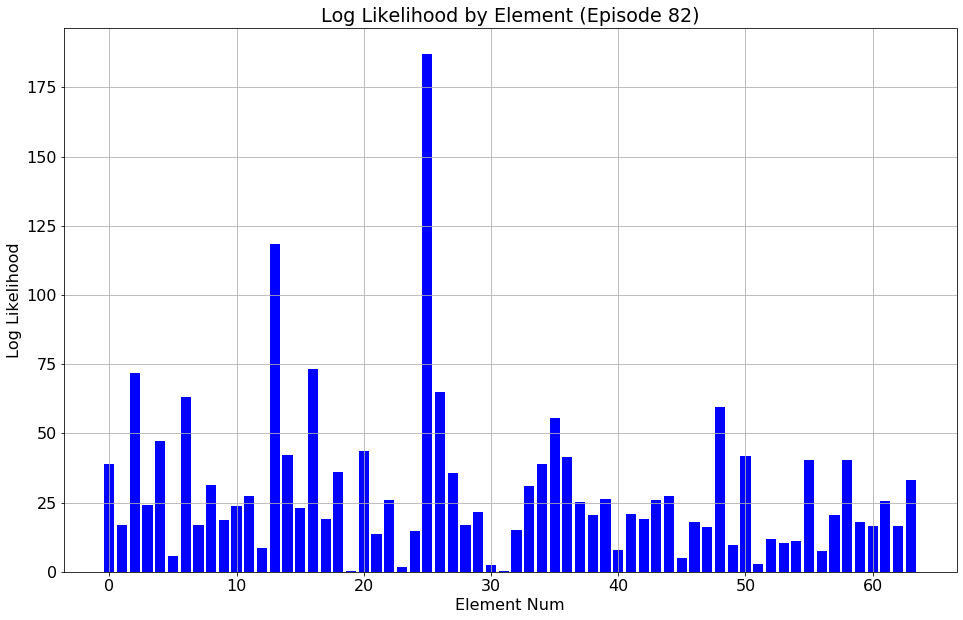

In [70]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

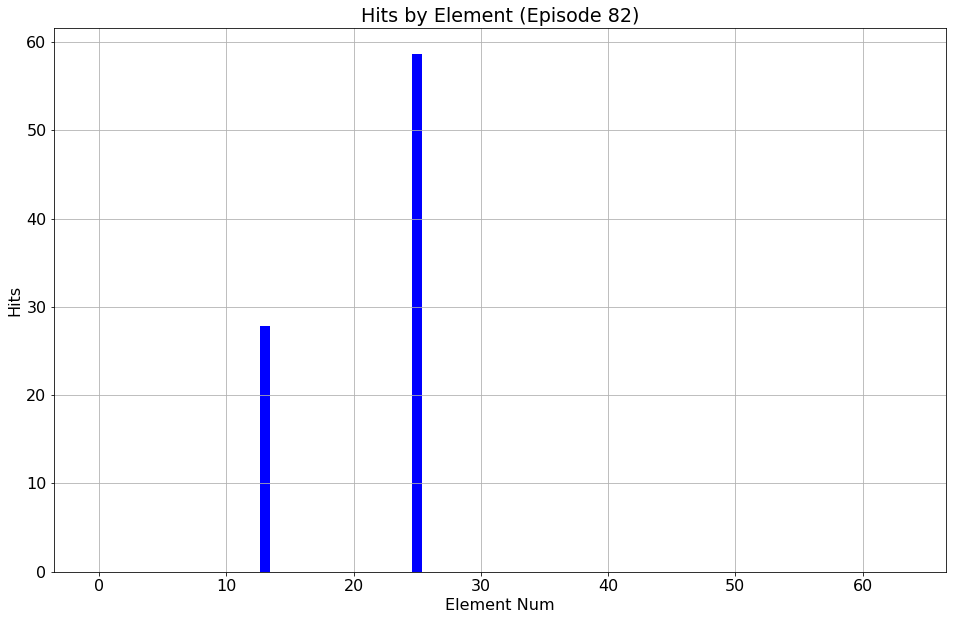

In [71]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

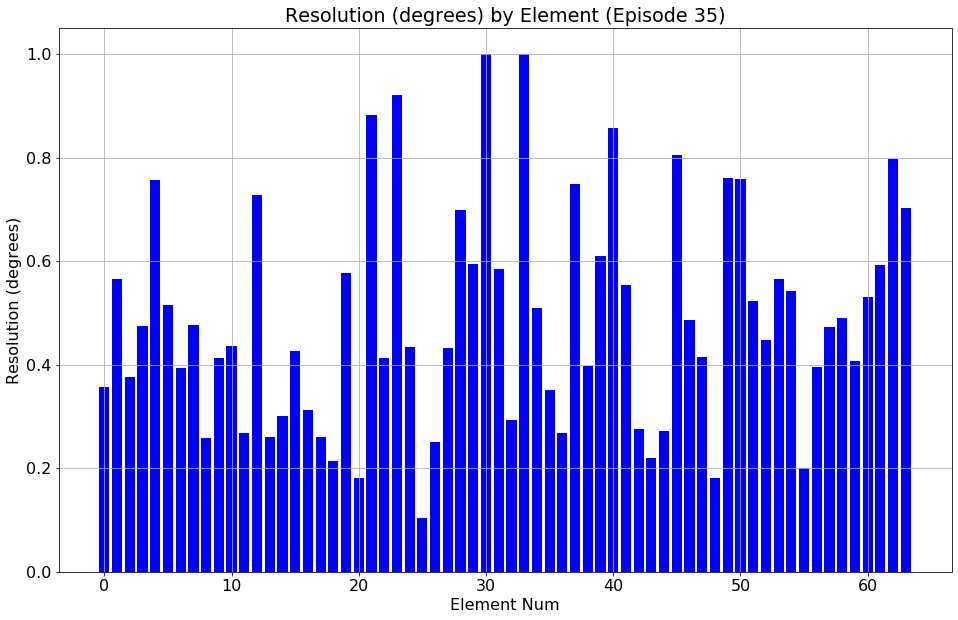

In [55]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('R_deg', sorted=False)

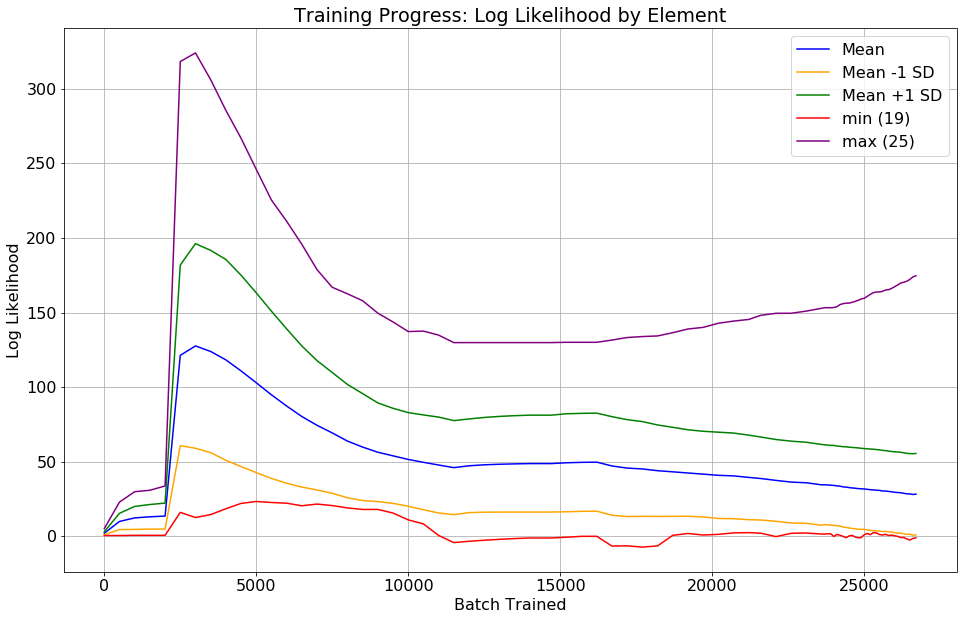

In [61]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

In [63]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [ ]:
# Review fitted elements including nearest asteroid
elts_fit

In [ ]:
q_norm = elt_q_norm(elts=elts_fit, ast_num=elts_fit.nearest_ast_num)
elts_fit['nearest_ast_q_norm'] = q_norm

In [ ]:
# Review asteroids nearest to the fitted elements
elts_near

In [ ]:
# Find nearest asteroid to fitted elements - search on Covariance metric
elts_fit, elts_near = model.nearest_ast(search_type='cov')

In [ ]:
# # Filter for only the good ones
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 60)
# elts_fit[mask]

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# model.elts_near_ast

In [ ]:
model.elts_fit

In [ ]:
q_norm = elt_q_norm(elts=model.elts_fit, ast_num=model.elts_fit.nearest_ast_num)

In [ ]:
mask = q_norm < 1
np.round(q_norm[mask], 2)

In [ ]:
ast_elt_near_cov = nearest_ast_elt_cov(elts=model.elts_fit)

In [ ]:
ast_elt_near_cov

In [ ]:
dElt = ast_elt_near_cov[cols] - elts_fit[cols]
dElt[62:63]

In [ ]:
X_ast = elts_to_X_cov(ast_elt_near_cov)
U_ast = np.dot(X_ast, beta)
# np.linalg.norm(U_ast, axis=1)
X_ast[62]

In [ ]:
U_ast[62]

In [ ]:
X_elt = elts_to_X_cov(elts_fit)
U_elt = np.dot(U_ast, beta)
X_elt[62:63]

In [ ]:
U_elt[62]

In [ ]:
dU = U_elt - U_ast

In [ ]:
dU[62]

In [ ]:
np.linalg.norm(dU[62])

In [ ]:
ast_elt_near_cov[cols].loc[62].values

In [ ]:
# covariance type difference vs. nearest asteroid element
from nearest_asteroid import beta, X_beta, elts_to_X_cov

In [ ]:
ast_elt

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)